In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import mlflow
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
import mlflow.sklearn
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_features = pd.read_csv("prepared_data.csv")
df_features = df_features.fillna(0)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df_features["clean_msg"], df_features["target"],
                                                     random_state=42, stratify=df_features["target"], test_size=0.2)

In [4]:
import os

mlflow.set_tracking_uri("sqlite:///mlflow.db")
if mlflow.search_experiments("spams") == None:
    mlflow.create_experiment("spams")

if not os.path.exists("./tmp"):
    os.makedirs("tmp")

mlflow.set_experiment("spams")
mlflow.sklearn.autolog(disable=True)

In [5]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("transformer", FunctionTransformer(lambda x: x.astype(str))),
    ("tfidf",TfidfVectorizer()),
    ("lr", LogisticRegression())
])

grid = {
    "tfidf__max_df": [0.8,0.9],
    "tfidf__ngram_range": [(1,1), (2,2)],
    "tfidf__max_features": [1000,3000,5000],
    "lr__penalty": ["l1","l2","elasticnet"],
    "lr__fit_intercept": [True, False],
    "lr__solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    scoring=["recall","precision","f1"],
    refit="f1",
    verbose=2,
    return_train_score=True,
    cv=4
)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total t

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.1s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.1s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
960 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ibrahim/anaconda3/envs/rapids/lib/py

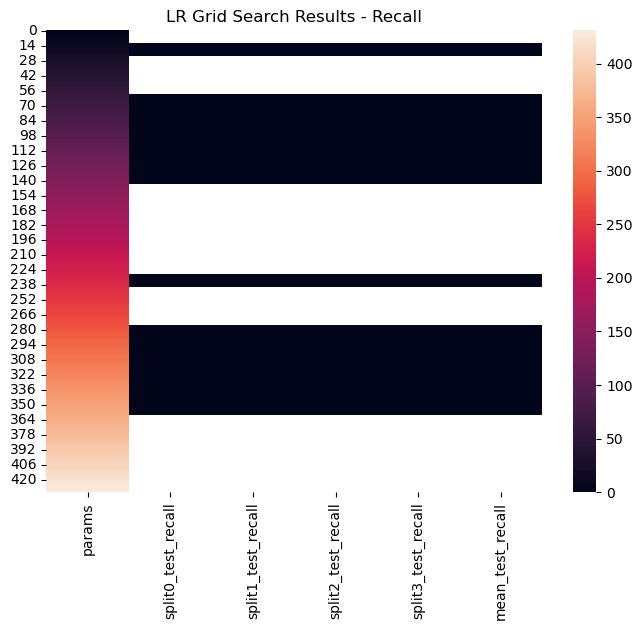

In [6]:
from sklearn.metrics import recall_score, precision_score, f1_score

grid_search.fit(X_train, y_train)

df_results = pd.DataFrame(grid_search.cv_results_)

X_train, X_test, y_train, y_test = train_test_split(
    df_features["clean_msg"],
    df_features["target"],
    test_size=0.2,
    random_state=42,
    stratify=df_features["target"]
)

with mlflow.start_run(run_name="lr_classifier"):
    best_nb = grid_search.best_estimator_
    y_pred = best_nb.predict(X_test)
    class_report = pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

    class_report.to_csv("./tmp/lr_report.csv")
    mlflow.log_artifact("./tmp/lr_report.csv", "lr_report.csv")

    df_results = pd.DataFrame(grid_search.cv_results_)
    df_results.to_csv("./tmp/lr_results.csv")

    mlflow.log_artifact("./tmp/lr_results.csv", "lr_results.csv")

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("type","Logistic Regression")
    
    mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path="best_lr_model")

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    mlflow.log_metrics({"Best F1 Score": f1, "Best Recall Score": recall, "Best Precision Score": precision})

    for i in range(0,len(df_results["params"])):
        mlflow.log_metrics({
                            "lr_test_recall": df_results.at[i,"mean_test_recall"],
                            "lr_test_precision": df_results.at[i,"mean_test_precision"],
                            "lr_test_f1": df_results.at[i,"mean_test_f1"],
                            "lr_train_recall": df_results.at[i,"mean_train_recall"],
                            "lr_train_precision": df_results.at[i,"mean_train_precision"],
                            "lr_train_f1": df_results.at[i,"mean_train_f1"]
            }, step=i)
        
    mlflow.log_metrics({"mean_test_recall": df_results["mean_test_recall"].mean(),
                                "mean_test_precision": df_results["mean_test_precision"].mean(),
                                "mean_test_f1": df_results["mean_test_f1"].mean(),
                                "mean_train_recall": df_results["mean_train_recall"].mean(),
                                "mean_train_precision": df_results["mean_train_precision"].mean(),
                                "mean_train_f1": df_results["mean_train_f1"].mean()})
    
    pivot_table = df_results[['params','split0_test_recall', 'split1_test_recall',
                'split2_test_recall', 'split3_test_recall', 'mean_test_recall']]
    pivot_table["params"] = pivot_table.index
    plt.figure(figsize=(8, 6))
    sns.heatmap(data=pivot_table, annot=False)
    plt.title("LR Grid Search Results - Recall")
    plt.savefig("./tmp/grid_lr_heatmap.png")
    mlflow.log_artifact(local_path="./tmp/grid_lr_heatmap.png", artifact_path="grid_lr_heatmap.png")


In [7]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ("transformer", FunctionTransformer(lambda x: x.astype(str))),
    ("tfidf", TfidfVectorizer()),
    ("rf", RandomForestClassifier())
])

grid = {
    "tfidf__ngram_range": [(1,1), (2,2)],
    "rf__n_estimators": [50, 100,150],
    "rf__criterion": ["gini", "entropy", "log_loss"],
    "rf__max_depth": [5,10,15,20]    
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    verbose=1,
    scoring=["recall","precision","f1"],
    refit="f1",
    return_train_score=True,
    cv=4
)

grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('transformer',
                                        FunctionTransformer(func=<function <lambda> at 0x71da8b826c00>)),
                                       ('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': [5, 10, 15, 20],
                         'rf__n_estimators': [50, 100, 150],
                         'tfidf__ngram_range': [(1, 1), (2, 2)]},
             refit='f1', return_train_score=True,
             scoring=['recall', 'precision', 'f1'], verbose=1)

2025/02/09 22:01:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/tmp/ipykernel_50362/1135079799.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["params"] = pivot_table.index


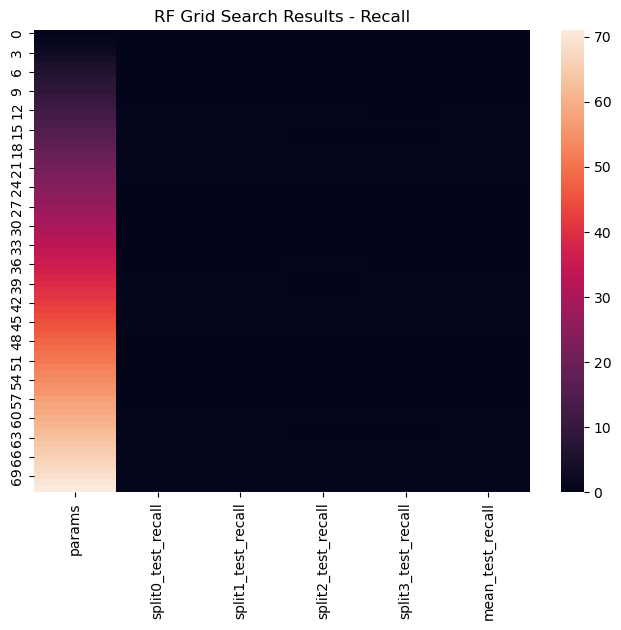

In [8]:
from sklearn.metrics import recall_score, precision_score, f1_score

with mlflow.start_run(run_name="rf_classifier"):
    best_nb = grid_search.best_estimator_
    y_pred = best_nb.predict(X_test)
    class_report = pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

    class_report.to_csv("./tmp/rf_report.csv")
    mlflow.log_artifact("./tmp/rf_report.csv", "rf_report.csv")

    mlflow.log_params(grid_search.best_params_)

    mlflow.log_param("type","Random Forest")

    df_results = pd.DataFrame(grid_search.cv_results_)
    df_results.to_csv("./tmp/rf_results.csv")

    mlflow.log_artifact("./tmp/rf_results.csv", "rf_results.csv")
    
    mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path="best_rf_model")

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    mlflow.log_metrics({"Best F1 Score": f1, "Best Recall Score": recall, "Best Precision Score": precision})

    for i in range(0,len(df_results["params"])):
        mlflow.log_metrics({
                            "rf_test_recall": df_results.at[i,"mean_test_recall"],
                            "rf_test_precision": df_results.at[i,"mean_test_precision"],
                            "rf_test_f1": df_results.at[i,"mean_test_f1"],
                            "rf_train_recall": df_results.at[i,"mean_train_recall"],
                            "rf_train_precision": df_results.at[i,"mean_train_precision"],
                            "rf_train_f1": df_results.at[i,"mean_train_f1"]
            }, step=i)
        
    mlflow.log_metrics({"mean_test_recall": df_results["mean_test_recall"].mean(),
                                "mean_test_precision": df_results["mean_test_precision"].mean(),
                                "mean_test_f1": df_results["mean_test_f1"].mean(),
                                "mean_train_recall": df_results["mean_train_recall"].mean(),
                                "mean_train_precision": df_results["mean_train_precision"].mean(),
                                "mean_train_f1": df_results["mean_train_f1"].mean()})
    
    pivot_table = df_results[['params','split0_test_recall', 'split1_test_recall',
                'split2_test_recall', 'split3_test_recall', 'mean_test_recall']]
    pivot_table["params"] = pivot_table.index
    plt.figure(figsize=(8, 6))
    sns.heatmap(data=pivot_table, annot=False)
    plt.title("RF Grid Search Results - Recall")
    plt.savefig("./tmp/grid_rf_heatmap.png")
    mlflow.log_artifact(local_path="./tmp/grid_rf_heatmap.png", artifact_path="grid_rf_heatmap.png")

In [9]:
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(
    df_features["clean_msg"],
    df_features["target"],
    test_size=0.2,
    random_state=42,
    stratify=df_features["target"]
)

pipe = Pipeline([
    ("transformer", FunctionTransformer(lambda x: x.astype(str))),
    ("tfidf", TfidfVectorizer()),
    ("nb", MultinomialNB())
])

grid = {
    "tfidf__max_features": [1000, 3000, 5000],
    "nb__alpha": [i/2 for i in range(1,40)],
    "nb__fit_prior": [True, False]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    scoring=["recall", "precision", "f1"],
    refit="recall",
    cv=4,
    verbose=2,return_train_score=True
)

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 234 candidates, totalling 936 fits
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfi

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

[CV] END nb__alpha=18.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

[CV] END nb__alpha=19.0, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

[CV] END nb__alpha=19.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('transformer',
                                        FunctionTransformer(func=<function <lambda> at 0x71da7f4fc220>)),
                                       ('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0,
                                       4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0,
                                       8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5,
                                       12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, ...],
                         'nb__fit_prior': [True, False],
                         'tfidf__max_features': [1000, 3000, 5000]},
             refit='recall', return_train_score=True,
             scoring=['recall', 'precision', 'f1'], verbose=2)

2025/02/09 22:02:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/tmp/ipykernel_50362/1780785939.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["params"] = pivot_table.index


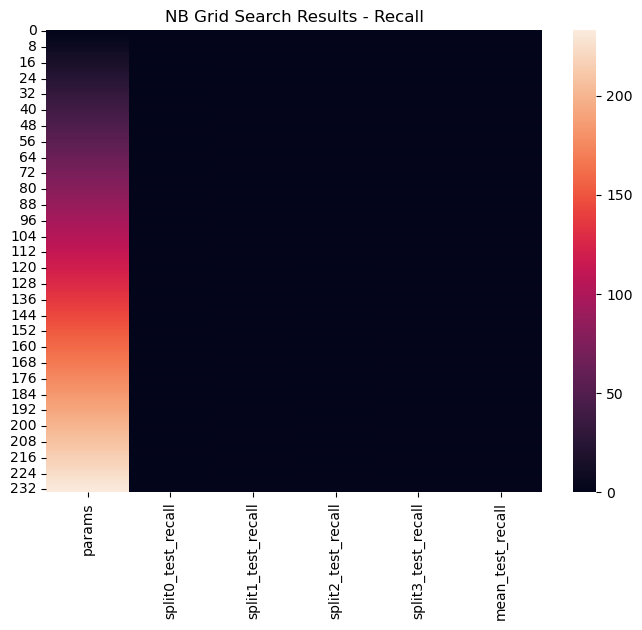

In [10]:
from sklearn.metrics import recall_score, precision_score, f1_score

df_results = pd.DataFrame(grid_search.cv_results_)

with mlflow.start_run(run_name="nb_classifier"):
    best_nb = grid_search.best_estimator_
    y_pred = best_nb.predict(X_test)
    class_report = pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

    class_report.to_csv("./tmp/nb_report.csv")
    mlflow.log_artifact("./tmp/nb_report.csv", "nb_report.csv")

    df_results = pd.DataFrame(grid_search.cv_results_)
    df_results.to_csv("./tmp/nb_results.csv")

    mlflow.log_artifact("./tmp/nb_results.csv", "nb_results.csv")
    
    mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path="best_nb_model")

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("type","Naive Bayes")

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    mlflow.log_metrics({"Best F1 Score": f1, "Best Recall Score": recall, "Best Precision Score": precision})

    for i in range(0,len(df_results["params"])):
        mlflow.log_metrics({
                            "nb_test_recall": df_results.at[i,"mean_test_recall"],
                            "nb_test_precision": df_results.at[i,"mean_test_precision"],
                            "nb_test_f1": df_results.at[i,"mean_test_f1"],
                            "nb_train_recall": df_results.at[i,"mean_train_recall"],
                            "nb_train_precision": df_results.at[i,"mean_train_precision"],
                            "nb_train_f1": df_results.at[i,"mean_train_f1"]
            }, step=i)
        
    mlflow.log_metrics({"mean_test_recall": df_results["mean_test_recall"].mean(),
                                "mean_test_precision": df_results["mean_test_precision"].mean(),
                                "mean_test_f1": df_results["mean_test_f1"].mean(),
                                "mean_train_recall": df_results["mean_train_recall"].mean(),
                                "mean_train_precision": df_results["mean_train_precision"].mean(),
                                "mean_train_f1": df_results["mean_train_f1"].mean()})
    
    pivot_table = df_results[['params','split0_test_recall', 'split1_test_recall',
                'split2_test_recall', 'split3_test_recall', 'mean_test_recall']]
    pivot_table["params"] = pivot_table.index
    plt.figure(figsize=(8, 6))
    sns.heatmap(data=pivot_table, annot=False)
    plt.title("NB Grid Search Results - Recall")
    plt.savefig("./tmp/grid_nb_heatmap.png")
    mlflow.log_artifact(local_path="./tmp/grid_nb_heatmap.png", artifact_path="grid_nb_heatmap.png")


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features[["char_count","digit_count","exclamation_count","dollar_count","sentiment"]],
    df_features["target"],
    test_size=0.2,
    random_state=42,
    stratify=df_features["target"]
)

In [12]:
class SVClassifier():
    def __init__(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            df_features["clean_msg"],
            df_features["target"],
            random_state=42,
            test_size=0.2,
            stratify=df_features["target"]
        )

        self.pipe = Pipeline([
            ("to_str", FunctionTransformer(lambda x: x.astype(str))),
            ("tfidf", TfidfVectorizer()),
            ("svc", SVC())
        ])

        self.grid = {
            "tfidf__max_df": [0.8,0.9],
            "tfidf__ngram_range": [(1,1), (1,2), (2,2), (2,3)],
            "svc__C": [0.1,1,10],
            "svc__kernel": ["linear","rbf"],
            "svc__gamma": ["scale", "auto"]
        }

        self.grid_search = GridSearchCV(
            estimator=self.pipe,
            param_grid=self.grid,
            scoring=["recall","precision","f1"],
            verbose=2,
            refit="recall",
            return_train_score=True,
            cv=4
        )

    def tuning(self):
        self.grid_search.fit(self.X_train, self.y_train)

    def train(self):
        with mlflow.start_run(run_name="svc_model_tuning"):
            mlflow.set_tag("model_name","svc")

            self.tuning()

            mlflow.log_param("Best Parameters",self.grid_search.best_params_)
            mlflow.log_metric("Best Recall Score", self.grid_search.best_score_)

            df_results = pd.DataFrame(self.grid_search.cv_results_)
            df_results.to_csv("./tmp/svc_results.csv")
            mlflow.log_artifact(local_path="./tmp/svc_results.csv", artifact_path="svc_results.csv")

            mlflow.log_params(grid_search.best_params_)
            mlflow.log_param("type","SVC")

            for i in range(0, len(df_results["params"])):
                mlflow.log_metrics({"svc_test_recall": df_results.at[i,"mean_test_recall"],
                                    "svc_test_precision": df_results.at[i,"mean_test_precision"],
                                    "svc_test_f1": df_results.at[i,"mean_test_f1"],
                                    "svc_train_recall": df_results.at[i,"mean_train_recall"],
                                    "svc_train_precision": df_results.at[i,"mean_train_precision"],
                                    "svc_train_f1": df_results.at[i,"mean_train_f1"]}, step=i)

            mlflow.log_metrics({"Best Precision Score": df_results["mean_test_precision"].max(),
                               "Best F1 Score": df_results["mean_test_f1"].max()})

            mlflow.log_metrics({"mean_test_recall": df_results["mean_test_recall"].mean(),
                                "mean_test_precision": df_results["mean_test_precision"].mean(),
                                "mean_test_f1": df_results["mean_test_f1"].mean(),
                                "mean_train_recall": df_results["mean_train_recall"].mean(),
                                "mean_train_precision": df_results["mean_train_precision"].mean(),
                                "mean_train_f1": df_results["mean_train_f1"].mean()})
                
            y_pred = self.grid_search.best_estimator_.predict(self.X_test)
                
            report = classification_report(self.y_test, y_pred, output_dict=True)
            report = pd.DataFrame(report).transpose().to_csv("./tmp/svc_classification_report.csv")
            mlflow.log_artifact("./tmp/svc_classification_report.csv")

            pivot_table = df_results[['params','split0_test_recall', 'split1_test_recall',
                'split2_test_recall', 'split3_test_recall', 'mean_test_recall']]
            pivot_table["params"] = pivot_table.index
            plt.figure(figsize=(8, 6))
            sns.heatmap(data=pivot_table, annot=True)
            plt.title("SVC Grid Search Results - Recall")
            plt.savefig("./tmp/grid_svc_heatmap.png")
            mlflow.log_artifact(local_path="./tmp/grid_svc_heatmap.png", artifact_path="grid_svc_heatmap.png")

            mlflow.sklearn.log_model(self.grid_search.best_estimator_, artifact_path="best_svc_model")

Fitting 4 folds for each of 96 candidates, totalling 384 fits
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.8s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.8s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.8s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.8s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.8s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.8s
[CV] END svc__C=0.1, svc__gamma=

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.7s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=1, svc__ga

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=10, s

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/tmp/ipykernel_50362/2399060654.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["params"] = pivot_table.index
2025/02/09 22:07:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


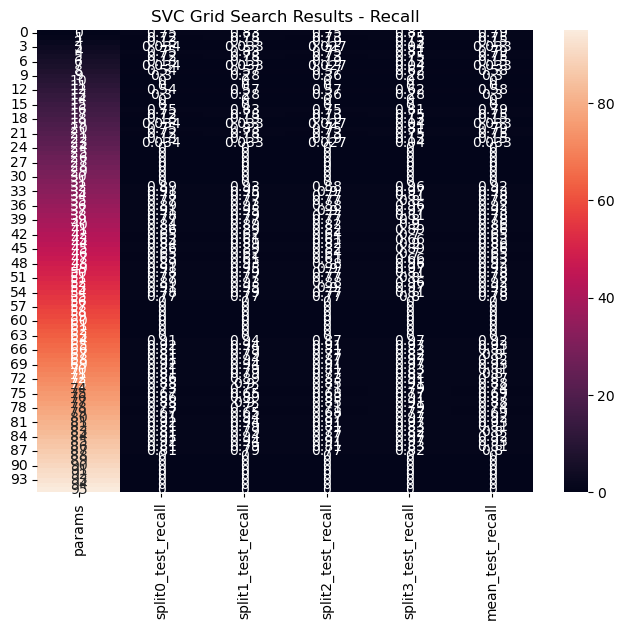

In [13]:
svc = SVClassifier()
svc.train()

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END ..........algorithm=auto, n_jobs=2, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=2, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=2, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=2, weights=uniform; total time=   0.0s
[CV] END .........algorithm=auto, n_jobs=2, weights=distance; total time=   0.0s
[CV] END .........algorithm=auto, n_jobs=2, weights=distance; total time=   0.0s
[CV] END .........algorithm=auto, n_jobs=2, weights=distance; total time=   0.0s
[CV] END .........algorithm=auto, n_jobs=2, weights=distance; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=4, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=4, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=4, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=4, wei

/tmp/ipykernel_50362/1715447488.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["params"] = pivot_table.index
2025/02/09 22:07:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


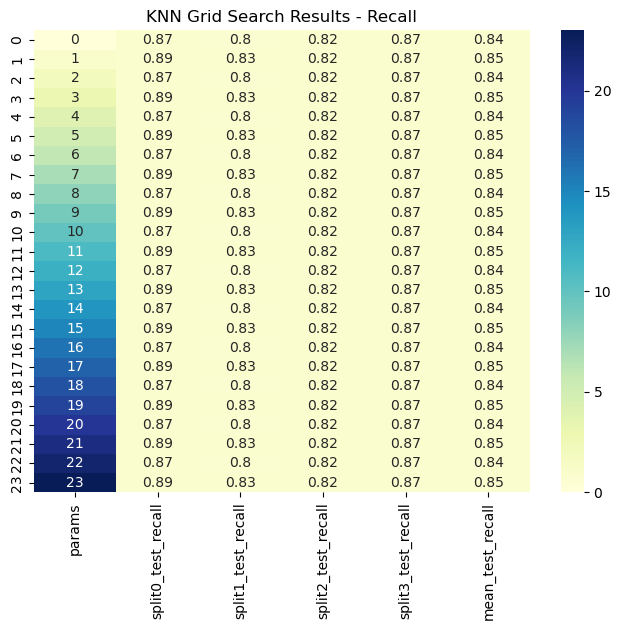

In [14]:
grid = {
    # "n_neighbors": range(3,16,2),
    "weights": ["uniform", "distance"],
    "algorithm": ["auto","ball_tree","kd_tree","brute"],
    "n_jobs": range(2,8,2)
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=grid,
    scoring=["recall","precision","f1"],
    verbose=2,
    refit="recall",
    return_train_score=True,
    cv=4
)


with mlflow.start_run(run_name="knn_model_tuning") as run:
    mlflow.set_tag("model_name", "knn")

    grid_search.fit(X_train, y_train)

    mlflow.log_param('KNN Best Parameters', grid_search.best_params_)
    mlflow.log_metric('Best Recall Score', grid_search.best_score_)

    mlflow.log_metrics({"Best Precision Score": df_results["mean_test_precision"].max(),
                               "Best F1 Score": df_results["mean_test_f1"].max()})

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("type","KNN")

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df.to_csv("./tmp/knn_results.csv")

    mlflow.log_metrics({"mean_test_recall": results_df["mean_test_recall"].mean(),
                        "mean_test_precision": results_df["mean_test_precision"].mean(),
                        "mean_test_f1": results_df["mean_test_f1"].mean(),
                        "mean_train_recall": results_df["mean_train_recall"].mean(),
                        "mean_train_precision": results_df["mean_train_precision"].mean(),
                        "mean_train_f1": results_df["mean_train_f1"].mean()})
    
    for i in range(0, len(df_results["params"])):
                mlflow.log_metrics({"knn_test_recall": df_results.at[i,"mean_test_recall"],
                                    "knn_test_precision": df_results.at[i,"mean_test_precision"],
                                    "knn_test_f1": df_results.at[i,"mean_test_f1"],
                                    "knn_train_recall": df_results.at[i,"mean_train_recall"],
                                    "knn_train_precision": df_results.at[i,"mean_train_precision"],
                                    "knn_train_f1": df_results.at[i,"mean_train_f1"]}, step=i)

    y_pred = grid_search.best_estimator_.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_csv = "./tmp/classification_report.csv"
    report_df.to_csv(report_csv)
    mlflow.log_artifact(report_csv)

    pivot_table = results_df[['params','split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall',
       'mean_test_recall']]
    pivot_table["params"] = pivot_table.index
    plt.figure(figsize=(8, 6))
    sns.heatmap(data=pivot_table, annot=True, cmap="YlGnBu")
    plt.title("KNN Grid Search Results - Recall")
    plt.savefig("./tmp/KNN_grid_search_heatmap.png")
    mlflow.log_artifact(local_path="./tmp/KNN_grid_search_heatmap.png", artifact_path="KNN_grid_search_heatmap.png")

    mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path="best_knn_model")